In [1]:
# results obtained from E1
degree = 3
compression_rate = 0.3

In [2]:
from utils.data import load_ucr_data_short, load_ucr_dataset

# load data
#data = load_ucr_data_short()
data = load_ucr_dataset(74)
print("number of time series:", len(data.index))

number of time series: 399


MiddlePhalanxTW no. 0, 0.3% processed
number of data points: 80


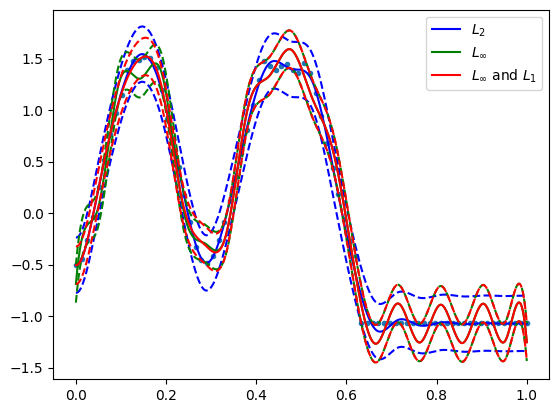

LSQ problem
number of data points: 76


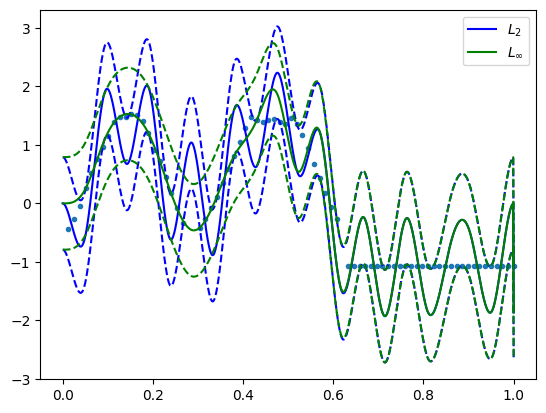

MiddlePhalanxTW no. 1, 0.5% processed
LSQ problem
number of data points: 80


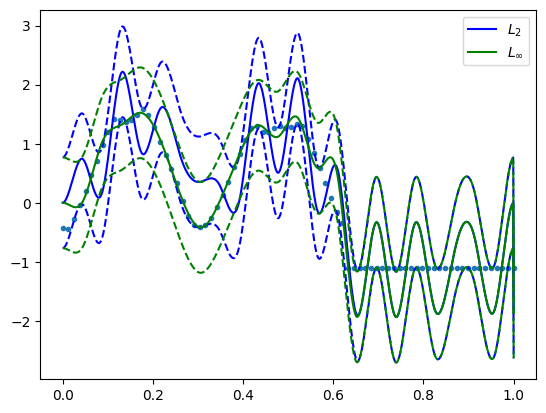

LSQ problem
number of data points: 79


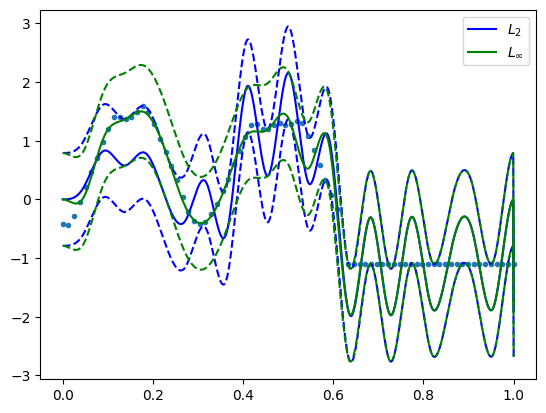

MiddlePhalanxTW no. 2, 0.8% processed
LSQ problem
number of data points: 80


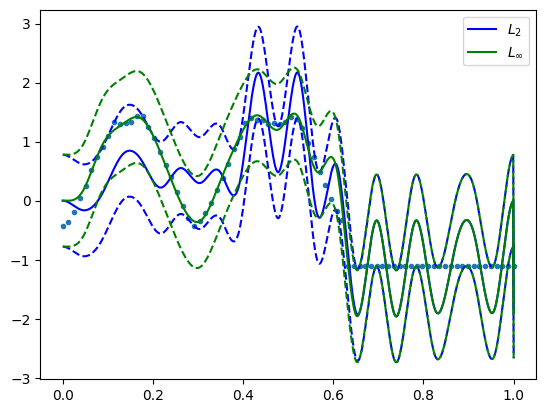

LSQ problem


KeyboardInterrupt: 

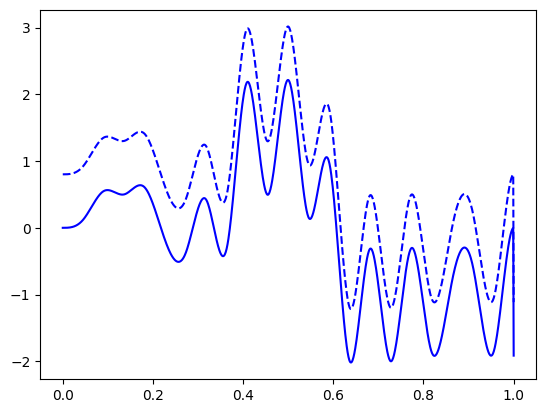

In [3]:
import numpy as np
import scipy.interpolate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.plot import plot_inverse_DFT, plot_splines
from utils.data import remove_outliers
from utils.spline import generate_coeff_counts, generate_knot_vector_from_coeff_count, calculate_max_dist
from utils.fit import fit_max_spline, fit_max_l1_spline, fit_PAA, fit_DFT, calculate_inverse_DFT
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.spline import evaluate_spline
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt

results = []
total_rows = len(data.index)
for idx, (_, row) in enumerate(data.iterrows(), 1):
    ts_with_outliers = row['data']
    ts_without_outliers = remove_outliers(ts_with_outliers)
    ts = [(0, ts_with_outliers), (len(ts_with_outliers) - len(ts_without_outliers), ts_without_outliers)]

    print(f"{row['dataset']} no. {row['num']}, {round(idx / total_rows * 100, 1)}% processed")

    for num_outliers_removed, time_series in ts:
        num_coeffs = generate_coeff_counts(len(time_series), degree, compression_ratios=[compression_rate])[0]
        knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=num_coeffs)

        for method, degree in [('L8', degree), ('L8 and L1', degree), ('LSQ', degree), ('PAA', 0), ('PLA', 1)]:
            max_dist = None
            result = None

            if method == 'LSQ':
                try:
                    result = scipy.interpolate.make_lsq_spline([x[0] for x in time_series], [x[1] for x in time_series],
                                                               knots, k=degree).c
                    max_dist = calculate_max_dist(knots, result, degree, time_series)
                except Exception as e:
                    #print(f"LSQ problem: {e}")
                    print("LSQ problem")
                    continue

            if method == 'L8 and L1':
                result = fit_max_l1_spline(time_series, knots, degree, eps=0.000001)[1]
                max_dist = calculate_max_dist(knots, result, degree, time_series)[0]
            else:
                max_dist, result = fit_max_spline(time_series, knots, degree)

            if max_dist is not None and result is not None:
                fitted_spline = [evaluate_spline(knots, result, degree, x[0]) for x in time_series]
                mse = mean_squared_error(fitted_spline, [x[1] for x in time_series])
                mae = mean_absolute_error(fitted_spline, [x[1] for x in time_series])
                if method == 'L8 and L1':
                    max_dist = calculate_max_dist(knots, result, degree, time_series)[0]

                results.append({
                    'dataset': row['dataset'],
                    'num': row['num'],
                    'num_data_pts': len(time_series),
                    'num_outliers_removed': num_outliers_removed,
                    'num_coeffs': num_coeffs,
                    'method': method,
                    'max_dist': max_dist,
                    'MSE': mse,
                    'MAE': mae
                })
            
        plot_splines(axis=plt, knots=knots, degree=degree,data=time_series, plot_PAA=False, plot_PLA=False)

        # DFT
        result = fit_DFT(time_series, num_coeffs)
        fitted_curve = calculate_inverse_DFT(len(time_series), num_coeffs, result)
        max_dist = np.max(np.abs(fitted_curve - [x[1] for x in time_series]))
        mse = mean_squared_error(fitted_curve, [x[1] for x in time_series])
        mae = mean_absolute_error(fitted_curve, [x[1] for x in time_series])

        #plot_inverse_DFT(fitted_curve, time_series, num_coeffs)

        results.append({
            'dataset': row['dataset'],
            'num': row['num'],
            'num_data_pts': len(time_series),
            'num_outliers_removed': num_outliers_removed,
            'num_coeffs': num_coeffs,
            'method': 'DFT',
            'max_dist': max_dist,
            'MSE': mse,
            'MAE': mae
        })


In [ ]:
e2_results = pd.DataFrame(results)
mean_values = e2_results.groupby('method').agg({'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values

In [ ]:
import pandas as pd

df_no_outliers = e2_results[e2_results['num_outliers_removed'] == 0]

df_with_outliers = e2_results[e2_results['num_outliers_removed'] > 0]

mean_values_no_outliers = df_no_outliers.groupby('method').agg(
    {'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values_no_outliers.rename(columns={'max_dist': 'max_dist w/o o.', 'MSE': 'MSE w/o o.', 'MAE': 'MAE w/o o.'},
                               inplace=True)

mean_values_with_outliers = df_with_outliers.groupby('method').agg(
    {'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values_with_outliers.rename(columns={'max_dist': 'max_dist', 'MSE': 'MSE', 'MAE': 'MAE'}, inplace=True)

mean_values_combined = pd.merge(mean_values_with_outliers, mean_values_no_outliers, on='method', how='outer')

mean_values_combined


In [ ]:
import matplotlib.pyplot as plt

# Plot mean values
plt.figure(figsize=(10, 6))
plt.bar(mean_values['method'], mean_values['max_dist'], color='b', alpha=0.7, label='Mean Max Dist')
plt.bar(mean_values['method'], mean_values['MSE'], color='r', alpha=0.5, label='Mean MSE')
plt.bar(mean_values['method'], mean_values['MAE'], color='g', alpha=0.5, label='Mean MAE')
plt.xlabel('Method')
plt.ylabel('Mean Value')
plt.title('Mean Max Dist, MSE, and MAE per Method')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
